In [ ]:
import os
try:
    os.environ["DISPLAY"]
except:
    os.environ["SDL_VIDEODRIVER"] = "dummy"
os.environ["SDL_VIDEODRIVER"] = "dummy"

In [4]:
import torch
import torch.nn as nn
#from utils import v_wrap, set_init, push_and_pull, record
import torch.nn.functional as F
import torch.multiprocessing as mp
#from shared_adam import SharedAdam
import gym

In [5]:
class SharedAdam(torch.optim.Adam):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.99), eps=1e-8,
                 weight_decay=0):
        super(SharedAdam, self).__init__(params, lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        # State initialization
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                state['step'] = 0
                state['exp_avg'] = torch.zeros_like(p.data)
                state['exp_avg_sq'] = torch.zeros_like(p.data)

                # share in memory
                state['exp_avg'].share_memory_()
                state['exp_avg_sq'].share_memory_()

In [21]:
UPDATE_GLOBAL_ITER = 5
GAMMA = 0.9
MAX_EP = 3000

env = gym.make('CartPole-v0')
N_S = env.observation_space.shape[0]
N_A = env.action_space.n

In [22]:
class Net(nn.Module):
    def __init__(self, s_dim, a_dim):
        super(Net, self).__init__()
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.pi1 = nn.Linear(s_dim, 128)
        self.pi2 = nn.Linear(128, a_dim)
        self.v1 = nn.Linear(s_dim, 128)
        self.v2 = nn.Linear(128, 1)
        #set_init([self.pi1, self.pi2, self.v1, self.v2])
        self.distribution = torch.distributions.Categorical

    def forward(self, x):
        pi1 = torch.tanh(self.pi1(x))
        logits = self.pi2(pi1)
        v1 = torch.tanh(self.v1(x))
        values = self.v2(v1)
        return logits, values

    def choose_action(self, s):
        self.eval()
        logits, _ = self.forward(s)
        prob = F.softmax(logits, dim=1).data
        m = self.distribution(prob)
        return m.sample().numpy()[0]

    def loss_func(self, s, a, v_t):
        self.train()
        logits, values = self.forward(s)
        td = v_t - values
        c_loss = td.pow(2)
        
        probs = F.softmax(logits, dim=1)
        m = self.distribution(probs)
        exp_v = m.log_prob(a) * td.detach().squeeze()
        a_loss = -exp_v
        total_loss = (c_loss + a_loss).mean()
        return total_loss

In [23]:
def push_and_pull(opt, lnet, gnet, done, s_, bs, ba, br, gamma):
    if done:
        v_s_ = 0.               # terminal
    else:
        v_s_ = lnet.forward(torch.Tensor(s_[None]))[-1].data.numpy()[0, 0]

    buffer_v_target = []
    for r in br[::-1]:    # reverse buffer r
        v_s_ = r + gamma * v_s_
        buffer_v_target.append(v_s_)
    buffer_v_target.reverse()

    loss = lnet.loss_func(
        torch.Tensor(np.vstack(bs)),
        torch.Tensor(np.array(ba)),
        torch.Tensor(np.array(buffer_v_target)[:, None]))

    # calculate local gradients and push local parameters to global
    opt.zero_grad()
    loss.backward()
    for lp, gp in zip(lnet.parameters(), gnet.parameters()):
        gp._grad = lp.grad
    opt.step()

    # pull global parameters
    lnet.load_state_dict(gnet.state_dict())

def record(global_ep, global_ep_r, ep_r, res_queue, name):
    with global_ep.get_lock():
        global_ep.value += 1
    with global_ep_r.get_lock():
        if global_ep_r.value == 0.:
            global_ep_r.value = ep_r
        else:
            global_ep_r.value = global_ep_r.value * 0.99 + ep_r * 0.01
    res_queue.put(global_ep_r.value)
    print(
        name,
        "Ep:", global_ep.value,
        "| Ep_r: %.0f" % global_ep_r.value,
    )
    
class Worker(mp.Process):
    def __init__(self, gnet, opt, global_ep, global_ep_r, res_queue, name):
        super(Worker, self).__init__()
        self.name = 'w%02i' % name
        self.g_ep, self.g_ep_r, self.res_queue = global_ep, global_ep_r, res_queue
        self.gnet, self.opt = gnet, opt
        self.lnet = Net(N_S, N_A)           # local network
        self.env = gym.make('CartPole-v0').unwrapped

    def run(self):
        total_step = 1
        while self.g_ep.value < MAX_EP:
            s = self.env.reset()
            buffer_s, buffer_a, buffer_r = [], [], []
            ep_r = 0.
            while True:
                if self.name == 'w00':
                    self.env.render()
                a = self.lnet.choose_action(torch.Tensor(s[None]))
                s_, r, done, _ = self.env.step(a)
                if done: r = -1
                ep_r += r
                buffer_a.append(a)
                buffer_s.append(s)
                buffer_r.append(r)

                if total_step % UPDATE_GLOBAL_ITER == 0 or done:  # update global and assign to local net
                    # sync
                    push_and_pull(self.opt, self.lnet, self.gnet, done, s_, buffer_s, buffer_a, buffer_r, GAMMA)
                    buffer_s, buffer_a, buffer_r = [], [], []

                    if done:  # done and print information
                        record(self.g_ep, self.g_ep_r, ep_r, self.res_queue, self.name)
                        break
                s = s_
                total_step += 1
        self.res_queue.put(None)

Process w00:
Traceback (most recent call last):
  File "/home/hyunseok.hwang/anaconda3/envs/RL_scratch/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/tmp/ipykernel_35577/748472363.py", line 60, in run
    self.env.render()
  File "/home/hyunseok.hwang/anaconda3/envs/RL_scratch/lib/python3.8/site-packages/gym/envs/classic_control/cartpole.py", line 207, in render
    self.screen = pygame.display.set_mode((screen_width, screen_height))


w02 

pygame.error: No available video device


Ep: 1 | Ep_r: 10w03
 Ep: 2 | Ep_r: 10
w02 Ep: 3 | Ep_r: 10
w01 w03Ep: Ep:  45  | Ep_r: 10| Ep_r: 10

w02 Ep: 6 | Ep_r: 10
w01 Ep: 7w02  | Ep_r: 10Ep:
 8 | Ep_r: 11
w03 Ep: 9 | Ep_r: 11
w02 Ep: 10 w01| Ep_r: 11 
Ep: 11 w03| Ep_r: 11 
Ep: 12 | Ep_r: 11
w02 Ep: 13 | Ep_r: 11
w01 Ep: 14 | Ep_r: 11
w01 Ep: 15 | Ep_r: 11
w03 Ep: 16 | Ep_r: 11
w01w02  Ep:Ep:w03   1718 Ep: | Ep_r: 12 | Ep_r: 12

19 | Ep_r: 12
w01 Ep: 20 w02| Ep_r: 12 
Ep: 21 | Ep_r: 12
w03 Ep: 22 | Ep_r: 13
w02 w01Ep:  Ep:23  24| Ep_r: 13 
| Ep_r: 13
w03 Ep: 25 | Ep_r: 13
w01 

xcb_connection_has_error() returned true
xcb_connection_has_error() returned true


Ep:w02  26Ep:  | Ep_r: 1327
 w03| Ep_r: 13 
Ep: 28 | Ep_r: 13
w01 Ep: 29 w02| Ep_r: 13 
Ep: 30 | Ep_r: 13
w03 Ep: 31 | Ep_r: 13w01
 Ep: 32 | Ep_r: 13w02
 Ep: 33 | Ep_r: 13
w01 Ep: 34 | Ep_r: 13
w03 Ep: 35 | Ep_r: 13
w02 Ep: 36 | Ep_r: 13
w01 Ep: 37w02w03   | Ep_r: 13Ep:Ep:
  3839  | Ep_r: 13| Ep_r: 13

w01 Ep: w0240  Ep:| Ep_r: 13 
w0341  Ep:| Ep_r: 13 
42 | Ep_r: 13
w01 Ep: 43w02  | Ep_r: 13Ep:
w03  44Ep:  | Ep_r: 1345
 | Ep_r: 13
w03 Ep: w0146  Ep:| Ep_r: 13 
47 | Ep_r: 14
w02 Ep: 48 | Ep_r: 14
w03 Ep:w01  49Ep:  | Ep_r: 1450
 | Ep_r: 14
w02 Ep: 51 | Ep_r: 14
w03 Ep: 52 | Ep_r: 14w01
 Ep: 53 | Ep_r: 14
w02 Ep: w0354  Ep:| Ep_r: 14 w01
55  Ep:| Ep_r: 14 
56 | Ep_r: 14
w02w03  Ep:Ep:  5758  | Ep_r: 14| Ep_r: 14

w01 Ep: 59 | Ep_r: 14
w03 Ep: 60 | Ep_r: 14
w02 Ep: 61 | Ep_r: 14
w03 Ep:w01  62Ep:  | Ep_r: 1463
 | Ep_r: 14
w01 Ep: 64 | Ep_r: 14
w02 Ep: 65 w03| Ep_r: 14 
Ep: 66 | Ep_r: 14
w01 Ep: 67w02  | Ep_r: 14Ep:
 68 | Ep_r: 14
w03 Ep: 69 | Ep_r: 14
w02 Ep: 70 | Ep_r: 14
w03 w01Ep:  Ep

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 | Ep_r: 26
w02 Ep: w03522  Ep:| Ep_r: 26 
523 | Ep_r: 26
w03 Ep: w01524  Ep:| Ep_r: 26w02 
 525Ep:  | Ep_r: 26526
 | Ep_r: 26
w01 Ep: 527 | Ep_r: 26
w03 Ep: 528 | Ep_r: 26
w01 Ep: 529 | Ep_r: 26
w02 Ep:w03  530Ep:  | Ep_r: 27531
 | Ep_r: 27
w01 Ep: 532 w03| Ep_r: 27 
Ep: 533 | Ep_r: 27
w01 Ep: 534 | Ep_r: 26
w01 Ep: 535 | Ep_r: 26
w02 Ep:w03  536Ep:  | Ep_r: 27537
 | Ep_r: 27
w02 Ep:w01  Ep:538  539| Ep_r: 27
 | Ep_r: 27w03
 Ep: 540 | Ep_r: 28
w02 Ep: 541 | Ep_r: 27w01
 Ep: 542 | Ep_r: 27
w03 Ep: 543 w01| Ep_r: 28 
Ep: 544 | Ep_r: 28
w02 Ep: 545 | Ep_r: 28
w03 Ep: 546 | Ep_r: 28
w02 Ep:w01  547Ep:  | Ep_r: 28548
 | Ep_r: 28
w03 Ep: 549 | Ep_r: 28
w01 Ep: 550w02 | Ep_r: 28 
Ep: 551w03  | Ep_r: 28
Ep: 552 | Ep_r: 28
w01 Ep: w02553  Ep:| Ep_r: 28 
554 | Ep_r: 28
w03 Ep: 555 | Ep_r: 28
w01 Ep: 556 | Ep_r: 28
w02 Ep: 557 | Ep_r: 28
w03 Ep: 558 | Ep_r: 28
w01 Ep: 559 | Ep_r: 28
w03 Ep: 560 | Ep_r: 28
w01 Ep: w02561  Ep:| Ep_r: 27 
562 | Ep_r: 28
w01w02  w03Ep:Ep:   Ep:563564   565| Ep_r: 28

w02 Ep: 877 | Ep_r: 53
w03w02 w01 Ep: Ep: Ep: 878 879 880 | Ep_r: 54 | Ep_r: 54
| Ep_r: 55

w03 Ep: 881 | Ep_r: 55
w01 Ep: 882 | Ep_r: 55
w03 Ep: 883 | Ep_r: 56
w01 Ep: w02884  Ep:| Ep_r: 56 
885 | Ep_r: 58
w01 Ep: 886 | Ep_r: 58
w03w02  Ep:Ep:  887888  | Ep_r: 59| Ep_r: 59
w01
 Ep: 889 | Ep_r: 59
w03 Ep:w02  890Ep:  | Ep_r: 59891
 | Ep_r: 59
w02 Ep: w03892  Ep:| Ep_r: 59 
893 | Ep_r: 60
w01 Ep: 894 | Ep_r: 62
w02 Ep: 895 | Ep_r: 62w01
 Ep: 896 | Ep_r: 62
w02 Ep: 897 | Ep_r: 61
w01 Ep:w03  898Ep:  | Ep_r: 61899
 | Ep_r: 62
w02 Ep: 900 | Ep_r: 62
w03 Ep: 901 | Ep_r: 63
w01 Ep: 902 | Ep_r: 64
w03 Ep: 903 | Ep_r: 64
w01 Ep: 904 w02| Ep_r: 63 
w03Ep:  Ep:905  906| Ep_r: 65 
| Ep_r: 65
w01 Ep: 907 | Ep_r: 64
w02 Ep: 908 | Ep_r: 64
w01 Ep: 909 | Ep_r: 64
w03 Ep: 910 | Ep_r: 65
w02 Ep: 911 | Ep_r: 65
w01 Ep:w03  912Ep:  | Ep_r: 65913
 | Ep_r: 65
w02 Ep: 914 | Ep_r: 65
w01w03  Ep:Ep:  915916  | Ep_r: 65| Ep_r: 65

w01w02  Ep:Ep:  917w03 918  | Ep_r: 64Ep:| Ep_r: 65
 
919 | Ep_r: 64
w01 Ep: 920

 | Ep_r: 1661216
 | Ep_r: 165
w03 Ep: w021217  Ep:| Ep_r: 165 
1218 | Ep_r: 165
w01 Ep: 1219 | Ep_r: 165
w03 Ep: 1220 | Ep_r: 165
w01 Ep: 1221w02  Ep:| Ep_r: 165 
1222 | Ep_r: 166w03
 Ep: 1223 | Ep_r: 166
w01 Ep: 1224 | Ep_r: 166
w02 Ep: 1225 | Ep_r: 165
w03 Ep: 1226 | Ep_r: 166
w01 Ep: 1227 | Ep_r: 167
w02 Ep: 1228 w03| Ep_r: 168 
Ep: 1229 | Ep_r: 167
w03 Ep: 1230 | Ep_r: 167
w02 Ep: 1231 | Ep_r: 167
w01 Ep: 1232 | Ep_r: 169
w03 Ep: 1233 | Ep_r: 169
w02 Ep: 1234 | Ep_r: 170w01
 Ep: 1235 | Ep_r: 170
w03 Ep: 1236 | Ep_r: 170
w01 Ep: 1237 | Ep_r: 170
w02 Ep: 1238 | Ep_r: 170
w03 Ep: 1239 | Ep_r: 170
w02 Ep: 1240 | Ep_r: 171
w01 Ep: 1241 | Ep_r: 173
w03 Ep: 1242 | Ep_r: 174
w01 Ep: 1243 | Ep_r: 173
w02 Ep:w03  1244Ep:  | Ep_r: 1751245
 | Ep_r: 175
w01 Ep: 1246 | Ep_r: 176
w03 Ep: 1247 | Ep_r: 176
w02 Ep: w011248  Ep:| Ep_r: 177 
1249 | Ep_r: 177
w03 Ep: 1250 | Ep_r: 177
w01 Ep: 1251 | Ep_r: 176
w02 Ep: 1252 | Ep_r: 177
w03 Ep: 1253 | Ep_r: 177
w01 Ep: 1254 | Ep_r: 178
w03 Ep: 1255 | Ep_r:

w01 Ep: 1543 | Ep_r: 224
w02 Ep: 1544w03  | Ep_r: 223Ep:
 1545 | Ep_r: 224
w01 Ep: 1546 | Ep_r: 223
w02 Ep: 1547 | Ep_r: 223
w03 Ep:w01  1548Ep:  | Ep_r: 2251549
 | Ep_r: 224
w02 Ep: 1550 | Ep_r: 225
w01 Ep: 1551 | Ep_r: 227
w03 Ep: 1552 | Ep_r: 230w02
 Ep: 1553 | Ep_r: 232
w03 Ep: 1554 | Ep_r: 231
w02 Ep: 1555 | Ep_r: 232
w01 Ep: 1556 | Ep_r: 236
w03 Ep: 1557 | Ep_r: 237
w02 Ep: 1558 | Ep_r: 237
w01w03  Ep:Ep:  15591560  | Ep_r: 236| Ep_r: 236

w02 Ep: 1561 | Ep_r: 235
w01 Ep: 1562 | Ep_r: 234
w03 Ep: 1563 | Ep_r: 235w02
 Ep: 1564 | Ep_r: 234
w01 Ep: 1565 | Ep_r: 234
w03 Ep: 1566 w02| Ep_r: 233 
Ep: 1567 | Ep_r: 233
w01 Ep: 1568 | Ep_r: 232
w03 Ep: 1569 | Ep_r: 231
w02 Ep: 1570 | Ep_r: 231
w01 Ep:w03 1571  Ep: | Ep_r: 231
1572 | Ep_r: 230
w02 Ep: 1573 | Ep_r: 229
w01 Ep: 1574 w03| Ep_r: 228 
Ep: 1575 | Ep_r: 228
w02 w01Ep:  Ep:1576  1577| Ep_r: 229 
| Ep_r: 229
w03 Ep: 1578 | Ep_r: 229
w03 Ep: 1579 | Ep_r: 228
w01 Ep: 1580 | Ep_r: 229
w02 Ep: 1581 | Ep_r: 230
w01 Ep: 1582 | Ep_r: 231


w03 Ep: 1870 | Ep_r: 207w01
 Ep: 1871 | Ep_r: 206
w02 Ep: 1872 | Ep_r: 207
w01 Ep: 1873 | Ep_r: 207
w03 Ep: 1874 | Ep_r: 207
w02 Ep: 1875 | Ep_r: 206
w03 Ep: 1876 | Ep_r: 205
w01 Ep: 1877 | Ep_r: 206
w02 Ep: 1878 | Ep_r: 207
w03 Ep: 1879 | Ep_r: 207
w01 Ep: 1880 | Ep_r: 207
w02 Ep: 1881 | Ep_r: 206
w02 Ep:w03  1882Ep:  | Ep_r: 2061883
 | Ep_r: 206
w01 Ep: 1884 | Ep_r: 207
w02 Ep: 1885 | Ep_r: 207
w03 Ep: 1886 | Ep_r: 206
w01 Ep: 1887 | Ep_r: 207
w02 Ep: 1888 | Ep_r: 207
w01 Ep: 1889 | Ep_r: 206
w03 Ep: 1890 | Ep_r: 208
w02 Ep: 1891 | Ep_r: 207
w01 Ep: 1892 | Ep_r: 207
w03 Ep: 1893 | Ep_r: 206
w02 Ep: 1894 | Ep_r: 206
w01 Ep: 1895 | Ep_r: 205
w01 Ep: 1896 | Ep_r: 205
w02 Ep: 1897 | Ep_r: 207
w03 Ep: 1898 | Ep_r: 208
w02 Ep: 1899 | Ep_r: 208
w03 Ep: 1900 | Ep_r: 208
w03 Ep: 1901 | Ep_r: 207
w02 Ep: 1902 | Ep_r: 208
w01 Ep: 1903 | Ep_r: 211
w02 Ep: 1904 | Ep_r: 211
w03 Ep: 1905 | Ep_r: 211
w01 Ep: 1906 | Ep_r: 210
w02 Ep: 1907 | Ep_r: 210
w03 Ep: 1908 | Ep_r: 210
w03 Ep: 1909 | Ep_r: 210


w03 Ep: 2197 | Ep_r: 221
w01 Ep: 2198 | Ep_r: 221
w02 Ep: 2199 | Ep_r: 221
w03 Ep: 2200 | Ep_r: 220
w02 Ep: 2201 | Ep_r: 220
w01 Ep: 2202 | Ep_r: 221
w03 Ep: 2203 | Ep_r: 221
w02 Ep: 2204 | Ep_r: 221
w02 Ep: 2205 | Ep_r: 220
w01 Ep: 2206 | Ep_r: 222
w02 Ep: 2207 | Ep_r: 222
w03 Ep: 2208 | Ep_r: 225
w02 Ep: 2209 | Ep_r: 224
w02 Ep: 2210 | Ep_r: 225
w03 Ep: 2211 | Ep_r: 228
w01 Ep: 2212 | Ep_r: 234
w02 Ep: 2213 | Ep_r: 234
w03 Ep: 2214 | Ep_r: 234
w02 Ep: 2215 | Ep_r: 234
w03 Ep: 2216 | Ep_r: 234
w01 Ep: 2217 | Ep_r: 236
w02 Ep: 2218 | Ep_r: 235
w03 Ep: 2219 | Ep_r: 235
w01 Ep: 2220 | Ep_r: 236
w02 Ep: 2221 | Ep_r: 236
w03 Ep: 2222 | Ep_r: 236
w01 Ep: 2223 | Ep_r: 235
w02 Ep: 2224 | Ep_r: 234
w03 Ep: 2225 | Ep_r: 234
w01 Ep: 2226 | Ep_r: 233
w03 Ep: 2227 | Ep_r: 232
w01 Ep: 2228 | Ep_r: 232
w02 Ep: 2229 | Ep_r: 232
w03 Ep: 2230 | Ep_r: 233
w01 w02Ep:  Ep:2231  2232| Ep_r: 233
 | Ep_r: 233
w03 Ep: 2233 | Ep_r: 232
w01 Ep: 2234 | Ep_r: 232
w02 Ep: 2235 | Ep_r: 231
w01 Ep: 2236 | Ep_r: 230


w03 Ep: 2524 | Ep_r: 221
w01 Ep: 2525 | Ep_r: 221
w02 Ep: 2526 | Ep_r: 222
w03 Ep: 2527 | Ep_r: 221
w01 Ep: 2528 | Ep_r: 221
w02 Ep: 2529 | Ep_r: 221
w03 Ep: 2530 | Ep_r: 221
w02 Ep: 2531 | Ep_r: 221
w01 Ep: 2532 | Ep_r: 223
w03 Ep: 2533 | Ep_r: 223
w01 Ep: 2534 | Ep_r: 223
w02 Ep: 2535 | Ep_r: 225
w01 Ep: 2536 | Ep_r: 225
w03 Ep: 2537 | Ep_r: 229
w02w01  Ep:Ep:  25382539  | Ep_r: 231| Ep_r: 232

w03 Ep: 2540 | Ep_r: 232
w03 Ep: 2541 | Ep_r: 231
w02 Ep: 2542 | Ep_r: 232
w01 Ep: 2543 | Ep_r: 235
w03 Ep: 2544 | Ep_r: 235
w02 Ep: 2545 | Ep_r: 234
w01 Ep: 2546 | Ep_r: 234
w02 Ep: 2547 | Ep_r: 233
w03 w01Ep:  Ep:2548  2549| Ep_r: 234 
| Ep_r: 233
w03 Ep: 2550 | Ep_r: 232
w01 Ep: 2551 | Ep_r: 233
w02 Ep: 2552 | Ep_r: 234
w03 Ep: 2553 | Ep_r: 234
w02 Ep: 2554 | Ep_r: 233
w03 Ep: 2555 | Ep_r: 233
w01 Ep: 2556 | Ep_r: 234
w02 Ep: 2557 w03| Ep_r: 234 
Ep: 2558 | Ep_r: 233
w01 Ep: 2559 | Ep_r: 233
w03 Ep: 2560 | Ep_r: 232
w02 Ep: 2561 | Ep_r: 232
w01 Ep: 2562 | Ep_r: 233
w03 Ep: 2563 | Ep_r: 233


w03 Ep: 2851 | Ep_r: 265
w02 Ep: 2852 | Ep_r: 265
w02 Ep: 2853 | Ep_r: 265
w01 Ep: 2854 | Ep_r: 268
w03 Ep: 2855 | Ep_r: 273
w02 Ep: 2856 | Ep_r: 276
w03 Ep: 2857 | Ep_r: 275
w01 Ep: 2858 | Ep_r: 278
w02 Ep: 2859 | Ep_r: 279
w02 Ep: 2860 | Ep_r: 279
w01 Ep: 2861 | Ep_r: 278
w02 Ep: 2862 | Ep_r: 278
w03 Ep: 2863 | Ep_r: 285
w01 Ep: 2864 | Ep_r: 285
w02 Ep: 2865 | Ep_r: 285
w03 Ep: 2866 | Ep_r: 285
w02 Ep: 2867 | Ep_r: 285
w01 Ep: 2868 | Ep_r: 286
w03 Ep: 2869 | Ep_r: 287
w02 Ep: 2870 | Ep_r: 286
w01 Ep: 2871 | Ep_r: 286
w02 Ep: 2872 | Ep_r: 286
w03 Ep: 2873 | Ep_r: 287
w01 Ep: 2874 | Ep_r: 286
w02 Ep: 2875 | Ep_r: 286
w03 Ep: w02 2876Ep: | Ep_r: 287 2877
 | Ep_r: 286
w03 Ep: 2878 | Ep_r: 285
w01 Ep: 2879 | Ep_r: 286
w02 Ep: 2880 | Ep_r: 286
w03 Ep:w01 2881  Ep: | Ep_r: 2862882
 | Ep_r: 284
w02 Ep: 2883 | Ep_r: 283
w02 Ep: 2884 | Ep_r: 282
w03 Ep: 2885 | Ep_r: 282
w02 Ep: 2886 | Ep_r: 280
w03 Ep: 2887 | Ep_r: 279
w02 Ep: 2888 | Ep_r: 278
w03 Ep: 2889 | Ep_r: 277
w01 Ep: 2890 | Ep_r: 280


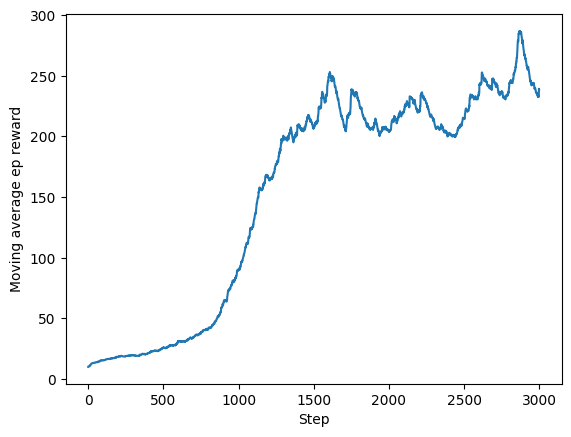

In [24]:
gnet = Net(N_S, N_A)        # global network
gnet.share_memory()         # share the global parameters in multiprocessing
opt = SharedAdam(gnet.parameters(), lr=1e-4, betas=(0.92, 0.999))      # global optimizer
global_ep, global_ep_r, res_queue = mp.Value('i', 0), mp.Value('d', 0.), mp.Queue()

#workers = [Worker(gnet, opt, global_ep, global_ep_r, res_queue, i) for i in range(mp.cpu_count())]
workers = [Worker(gnet, opt, global_ep, global_ep_r, res_queue, i) for i in range(4)]
[w.start() for w in workers]
res = []                    # record episode reward to plot
while True:
    r = res_queue.get()
    if r is not None:
        res.append(r)
    else:
        break
[w.join() for w in workers]

import matplotlib.pyplot as plt
plt.plot(res)
plt.ylabel('Moving average ep reward')
plt.xlabel('Step')
plt.show()

In [27]:
env._max_episode_steps

200